In [2]:
# Import various dependencies, including the relevant modules from the Perch
# repository. Note that "chirp" is the old name that the Perch team used, so any
# chirp modules imported here were installed as part of the Perch repository in
# one of the previous cells.

import collections
from collections import Counter
from etils import epath
from IPython.display import HTML
import ipywidgets as widgets
from IPython.display import display as ipy_display, HTML
import matplotlib.pyplot as plt
from ml_collections import config_dict
import numpy as np
import pandas as pd
from scipy.io import wavfile
import shutil
import tensorflow as tf
import tqdm

from chirp.inference import colab_utils
colab_utils.initialize(use_tf_gpu=True, disable_warnings=True)

from chirp import audio_utils
from chirp import config_utils
from chirp import path_utils
from chirp.inference import embed_lib
from chirp.inference import models
from chirp.inference import tf_examples
from chirp.models import metrics
from chirp.inference.search import bootstrap
from chirp.inference.search import search
from chirp.inference.search import display
from chirp.inference.classify import classify
from chirp.inference.classify import data_lib

import os

# If connected to a Colab GPU runtime we should see a GPU listed
tf.config.list_physical_devices()
tf.config.set_visible_devices([], 'GPU')

2024-11-12 15:12:15.757790: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 15:12:15.788844: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-12 15:12:15.788873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-12 15:12:15.789636: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 15:12:15.795427: I tensorflow/core/platform/cpu_feature_guar

In [3]:
sample_data_folder = "./Evaluation/eval_texel Data/"
output_directory = "./Evaluation/eval_texel Outputs/"

## Create ground truth data
The following section create a dataframe with 5 seconds window audio and their associated label based on wav files and raven pro annotation txt files using a sliding window approach.

In [ ]:
import os

def determine_label(annotations_in_window, start_window, end_window, wind_dur, annot_coverage_threshold=0.8, win_coverage_threshold=0.2):
    label = 'NEG'
    
    if not annotations_in_window.empty:
        # Calculate durations using vectorized operations
        annotations_in_window['Duration'] = np.minimum(end_window, annotations_in_window['End Time (s)']) - np.maximum(start_window, annotations_in_window['Begin Time (s)'])
        
        total_annotation_duration = annotations_in_window['Duration'].sum()

        if total_annotation_duration + 1e-5 > win_coverage_threshold * wind_dur:
            # Find the longest annotation
            longest_annotation = annotations_in_window.loc[annotations_in_window['Duration'].idxmax()]

            if 'POS' in longest_annotation.values:
                pos_column = longest_annotation.index[longest_annotation == 'POS'].tolist()
                return pos_column[0]
            elif 'UNK' in longest_annotation.values:
                label = 'UNK'
        
        for _, annotation in annotations_in_window.iterrows():
            # Return type of annotation as label if porpotion of the annotation (defined by annot_coverage_threshold) is in the windows
            # TODO - Work for binary labelling now, should be adapted for multi label (one column per label/hot labels)
            if annotation['Duration'] / (annotation['End Time (s)'] - annotation['Begin Time (s)']) >= annot_coverage_threshold - 1e-5:
                    return annotation['Type']

    return label

def sliding_window_cuting(waveform, df_annot=None, sr=16000, wind_dur=1.0, win_coverage_threshold=0.5, annot_coverage_threshold=0.5, overlap_ratio=0.0, verbose=0):
    '''
    Slide a waveform in window of wind_dur * sr length and save the chunks in a dataframe (output). If a dataframe of annotation in raven pro format is provided,
    the function will associate a label to the chunk depending on the presence/absence of annotation, and on the coverage parameters.

    Inputs
    waveform: waveform (np.array)
    sr: sampling rate (int)
    wind_dur: duration of the chunk (float)
    win_coverage_threshold: if an annotation cover a bigger proportion of the window than the value, the chunk is label positive, otherwise NEG (float between 0.0 and 1.0)
    annot_coverage_threshold: if a proportion of the annotation bigger than the value is contained in the chunk, chunk is positive, otherwise NEG (float between 0.0 and 1.0)
    overlap_ratio: time between two chunk start / hop_size in second (float)
    verbose: print info if = 1

    Outputs:
    df_chunks: pandas.DataFrame with keys (Audio, Starttime, Endtime, Label)
    '''
    # Calculate frame length in samples
    frame_length_sample = int(wind_dur * sr)
    step_size = int(frame_length_sample * (1 - overlap_ratio))

    # Calculate start times
    indices = np.arange(0, len(waveform) - frame_length_sample + 1, step_size)
    start_times = indices / sr
    end_times = start_times + wind_dur

    # Extract chunks
    chunks = [waveform[i:i+frame_length_sample] for i in indices]
    df_chunks = pd.DataFrame({'Audio': chunks, 'Starttime': start_times, 'Endtime': end_times})

    if df_annot is not None:
        labels = []
        df_annot_start = df_annot['Begin Time (s)'].values
        df_annot_end = df_annot['End Time (s)'].values

        for start, end in zip(start_times, end_times):
            # Find annotations in the current chunk
            mask = ((start < df_annot_start) & (df_annot_start < end)) | \
                   ((start < df_annot_end) & (df_annot_end < end)) | \
                   ((df_annot_start < start) & (end < df_annot_end))
            annotations_in_window = df_annot[mask]

            # Determine the label for the current chunk
            label = determine_label(annotations_in_window, start, end, wind_dur, annot_coverage_threshold, win_coverage_threshold)
            labels.append(label)

        # Assign labels to the DataFrame
        df_chunks['Label'] = labels

        if verbose == 1:
            print('Number of samples in each of the class:')
            print(df_chunks['Label'].value_counts())

    return df_chunks

In [7]:
# load wav files test list
dir_path = "./test_set/"
test_files_list = os.listdir(dir_path)

# Create a list of all wav files with files ending by .wav
wav_files = sorted([file for file in test_files_list if file.endswith('.wav')])
annot_files = sorted([file for file in test_files_list if file.endswith('.txt')])


In [8]:
# Load wav and files and create a GT dataframe with waveform, start and end time, label and filename
total_detection = 0
idx_list = []
df_chunks_list = pd.DataFrame()
df_annot_list = pd.DataFrame()
label_column_name = 'Type'
annotation_name = 'A'
model_sr = 32000

# Iterates the wav and annot files - must be sorted to make sure they correspond - no extra check here
for i in range(len(wav_files)):
    waveform = audio_utils.load_audio(dir_path+wav_files[i], model_sr)
    df_annot = pd.read_csv(dir_path+annot_files[i], sep='\t')
    # Only keep call A
    df_annot = df_annot[df_annot[label_column_name] == annotation_name]
    df_chunks = sliding_window_cuting(waveform, df_annot, wind_dur=5.0, win_coverage_threshold=0.2, annot_coverage_threshold=0.5, sr=32000)
    df_chunks['filename'] = wav_files[i]

    df_chunks_list = pd.concat([df_chunks_list, df_chunks])
    df_annot_list = pd.concat([df_annot_list, df_annot])
    
    if len(df_annot) > 0:
        idx_list.append(i)
        total_detection += len(df_annot)

# print(idx_list)
# df_chunks = sliding_window_cuting(waveform, df_annot, wind_dur=5.0, win_coverage_threshold=0.2, annot_coverage_threshold=0.5)
# remove index
df_chunks_list.reset_index(drop=True, inplace=True)
df_chunks_list['Label'].value_counts()

Label
NEG    7150
A        48
Name: count, dtype: int64

## Experimental code bellow
Bellow is the code I used to generates the plots to give a better idea of the evaluation I wanted to have. Might not work well

In [9]:
# Model specific parameters: PLEASE DO NOT CHANGE THE CODE IN THIS CELL.
config = config_dict.ConfigDict()
embed_fn_config = config_dict.ConfigDict()
embed_fn_config.model_key = 'taxonomy_model_tf'
model_config = config_dict.ConfigDict()

# The size of each "chunk" of audio.
model_config.window_size_s = 5.0

# The hop size
model_config.hop_size_s = 5.0

# All audio in this tutorial is resampled to 32 kHz.
model_config.sample_rate = 32000

# The location of the pre-trained model.
model_config.model_path = sample_data_folder + 'SurfPerch-model/'

# Only write embeddings to reduce size. The Perch codebase supports serializing
# a variety of metadata along with the embeddings, but for the purposes of this
# tutorial we will not need to make use of those features.
embed_fn_config.write_embeddings = True
embed_fn_config.write_logits = False
embed_fn_config.write_separated_audio = False
embed_fn_config.write_raw_audio = False

config.embed_fn_config = embed_fn_config
embed_fn_config.model_config = model_config

# These two settings can be used to break large inputs up into smaller chunks;
# this is especially helpful for dealing with long files or very large datasets.

config.shard_len_s = 10*60 # ADJUST FILELENGTH HERE (in sec)
config.num_shards_per_file = -1

# Number of parent directories to include in the filename. This allows us to
# process raw audio that lives in multiple directories.
config.embed_fn_config.file_id_depth = 1

# If your dataset is large its useful to split the TFRecords across multiple
# shards so I/O operations can be parallized.
config.tf_record_shards = 10

In [10]:
embed_fn = embed_lib.EmbedFn(**config.embed_fn_config)
print('\n\nLoading model(s)...')
embed_fn.setup()

print('\n\nTest-run of model...')
z = np.zeros([int(model_config.sample_rate * model_config.window_size_s)])
embed_fn.embedding_model.embed(z)
print('Setup complete!')



Loading model(s)...


Test-run of model...


2024-11-12 15:13:45.057662: I external/local_xla/xla/service/service.cc:168] XLA service 0x19f647d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-11-12 15:13:45.057721: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-11-12 15:13:45.351301: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-12 15:13:45.363915: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert
I0000 00:00:1731420827.830168   16353 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-11-12 15:13:47.845884: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


Setup complete!


## Load pretrained binary classifier
Here is the structure I used to evaluate perf on each model

In [12]:
# Load models in a dictionary
# each key is the number of samples used for training and contains a list of 5 models trained with different seeds
dataset_folder = 'september 2024/'
target_sound = 'fishA'
embedding_dim = 1280
num_classes = 2
train_examples_per_class = [2, 4, 8, 16, 32, 64, 128]
seed = np.arange(5)
model_dict = {}
model_per_nbr_sample = []

for nbr_example in train_examples_per_class:
    model_per_nbr_sample = []
    for i in seed:
        save_model_path = './Evaluation/eval_texel Outputs/' + dataset_folder + target_sound + '/models/model_' + str(nbr_example) + "samples_" + str(i) + '.ckpt'
        model_per_nbr_sample.append(classify.get_linear_model(embedding_dim, num_classes))
        model_per_nbr_sample[-1].load_weights(save_model_path).expect_partial()
    model_dict[nbr_example] = model_per_nbr_sample

## Extract and save embeddings for the test set
This code can take a long time to run (depending on computational power and size of the test set).
The embeddings are loaded in a npy file so this can be run only once.

In [118]:
# Only run ONCE!!!
embedding_list = []
for idx, chunk in tqdm(df_chunks_list.iterrows(), total=len(df_chunks_list)):
    output = embed_fn.embedding_model.embed(chunk['Audio'])
    emb_shape = output.embeddings.shape
    flat_emb = tf.reshape(output.embeddings, [-1, emb_shape[-1]])
    embedding_list.append(flat_emb)

# Save the embeddings as a numpy array
np.save('./Evaluation/eval_texel Outputs/' + dataset_folder + target_sound + '/test_set_embeddings/embeddings_test_set.npy', embedding_list)

100%|██████████| 7198/7198 [1:41:31<00:00,  1.18it/s]


### Embeddings and prediction are added to the dataframe
Embeddings are added to the dataframe to simplify verification
Prediction are also added for now, but will be removed to test several classifier later.

In [13]:
from tqdm import tqdm

embed_list_npy = np.load('./Evaluation/eval_texel Outputs/' + dataset_folder + target_sound + '/test_set_embeddings/embeddings_test_set.npy')

embedding_list_temp = []
prediction_list = []
logit_list = []

for idx, chunk in tqdm(df_chunks_list.iterrows(), total=len(df_chunks_list)):
    embedding_list_temp.append(embed_list_npy[idx][0])

df_chunks_list['Embedding'] = embedding_list_temp

# for idx, chunk in tqdm(df_chunks_list.iterrows(), total=len(df_chunks_list)):

#     logit = model(np.expand_dims(chunk['Embedding'], axis=0))
#     logit_list.append(logit.numpy())

#     # Get the predicted label
#     predicted_label = tf.argmax(logit, axis=1)
#     # Save the prediction in the df_chunk_list
#     prediction_list.append(predicted_label[0].numpy())

# df_chunks_list['Prediction'] = prediction_list


  0%|          | 0/7198 [00:00<?, ?it/s]

100%|██████████| 7198/7198 [00:00<00:00, 39009.77it/s]


### Simple function to display label, prediction and plot of a given sample for verification

In [14]:
def check_prediction(df_chunks_list, idx, display_plot=False):
    output = embed_fn.embedding_model.embed(df_chunks_list.loc[idx].Audio)
    emb_shape = output.embeddings.shape
    flat_emb = tf.reshape(output.embeddings, [-1, emb_shape[-1]])
    logit = model(flat_emb)
    prob = tf.nn.sigmoid(logit)
    assert (flat_emb[0].numpy() == df_chunks_list['Embedding'].iloc[idx]).all()
    print("Proba = ", prob.numpy())
    print(f"Label {df_chunks_list['Label'].iloc[idx]}, prediction {df_chunks_list['Prediction'].iloc[idx]}")
    if display_plot:
        display.plot_audio_melspec(df_chunks_list['Audio'].iloc[0], model_config.sample_rate)


In [ ]:
# Check mistakes

# Extract indices were predictions is wrong
false_negative_idx = df_chunks_list[(df_chunks_list['Label'] == 'A') & (df_chunks_list['Prediction'] != 1)].index
# Extract indices were predictions is right
false_positive_idx = df_chunks_list[(df_chunks_list['Label'] != 'A') & (df_chunks_list['Prediction'] == 1)].index

# print(df_chunks_list[['Label', 'Prediction']].iloc[false_negative_idx])
# print(df_chunks_list[['Label', 'Prediction']].iloc[false_positive_idx])

idx = false_negative_idx[0]
for idx in false_positive_idx:
    check_prediction(df_chunks_list, idx, display_plot=False)

## Compute different metrics and display confusion matrix

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

metrics_dict = {
    'precision': {},
    'recall': {},
    'f1': {},
    'auc_roc': {}
}

labels = df_chunks_list['Label'].replace({'A': 1, 'NEG': 0}).to_numpy().astype(int)

for nbr_example in tqdm(train_examples_per_class):
    precision_list, recall_list, f1_list, auc_roc_list = [], [], [], []

    for i in seed:
        prediction_list, logit_list = [], []
        for idx, chunk in tqdm(df_chunks_list.iterrows(),leave=False):
            
            model = model_dict[nbr_example][i]
            logit = model(np.expand_dims(chunk['Embedding'], axis=0))
            logit_list.append(logit.numpy())

            # Get the predicted label
            predicted_label = tf.argmax(logit, axis=1)
            # Save the prediction in the df_chunk_list
            prediction_list.append(predicted_label[0].numpy())
        
        predictions = np.array(prediction_list)
        logit_score = np.squeeze(np.array(logit_list))[:,1]

        # Add metrics to dictionary
        precision_list.append(precision_score(labels, predictions.astype(int), average='macro'))
        recall_list.append(recall_score(labels, predictions.astype(int), average='macro'))
        f1_list.append(f1_score(labels, predictions.astype(int), average='macro'))
        auc_roc_list.append(roc_auc_score(labels, logit_score))

        # Print metrics
        # print("Number of sample for training:", nbr_example)
        # print(f"Seed {i} - F1: {f1_list[-1]}, Precision: {precision_list[-1]}, Recall: {recall_list[-1]}, AUC-ROC: {auc_roc_list[-1]}")

    # Store metric lists in the dictionary
    metrics_dict['precision'][nbr_example] = precision_list
    metrics_dict['recall'][nbr_example] = recall_list
    metrics_dict['f1'][nbr_example] = f1_list
    metrics_dict['auc_roc'][nbr_example] = auc_roc_list

# Calculate and display confusion matrix from labels and predictions
# cm = confusion_matrix(labels.astype(int), predictions.astype(int))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()

  0%|          | 0/7 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [327]:
print(metrics_dict)

{'precision': {2: [0.5017533213690883, 0.5056481992127593, 0.5005403333785509, 0.5038050778946856, 0.5010543576733164], 4: [0.5083465138872311, 0.5053958546469506, 0.5051628758930903, 0.5026105775941273, 0.5013664628871539], 8: [0.5066025741847542, 0.5086730672693807, 0.5118508545051171, 0.5053490823242784, 0.5082614735142703], 16: [0.521625712880755, 0.5126710914483724, 0.5088482957052876, 0.5086405078974454, 0.5497995259193494], 32: [0.5526655227451417, 0.5762853672477851, 0.5481163263746157, 0.5796521174370284, 0.6816620737876856], 64: [0.740674273108636, 0.7485998319798376, 0.607112504537225, 0.5765400201592167, 0.5844472729629826], 128: [0.6042366741051831, 0.8151375531328772, 0.6560854766268555, 0.6691887226697353, 0.794589510164116]}, 'recall': {2: [0.5652884615384616, 0.7077855477855478, 0.5200553613053613, 0.6112645687645688, 0.5254195804195805], 4: [0.7389889277389277, 0.6836771561771562, 0.637062937062937, 0.5942249417249417, 0.5440005827505827], 8: [0.7289772727272728, 0.76

In [335]:
# save metrics_dict
import pickle
with open('./Evaluation/eval_texel Outputs/september 2024/fishA/results/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f)

In [20]:
# Load the results
import pickle
with open('./Evaluation/eval_texel Outputs/september 2024/fishA/results/metrics_dict.pkl', 'rb') as f:
    test_set_metric_dict = pickle.load(f)

## Load data from validation set evaluation

In [21]:
number_example_per_class = [2, 4, 8, 16, 32, 64, 128]

valid_metrics_dict = {
    'precision': {},
    'recall': {},
    'f1': {},
    'auc_roc': {}
}

for train_examples_per_class in number_example_per_class:
    valid_set_result_path = './Evaluation/eval_texel Outputs/' + dataset_folder + target_sound + '/results/validation_set/'+ str(train_examples_per_class) + 'metrics_dict.pickle'
    with open(valid_set_result_path, 'rb') as f:
        one_sample_number_valid_metric_dict = pickle.load(f)
    # Populate valid_metrics_dict with pickles data
    valid_metrics_dict['precision'][train_examples_per_class] = one_sample_number_valid_metric_dict['precision'][train_examples_per_class]
    valid_metrics_dict['recall'][train_examples_per_class] = one_sample_number_valid_metric_dict['recall'][train_examples_per_class]
    valid_metrics_dict['f1'][train_examples_per_class] = one_sample_number_valid_metric_dict['f1'][train_examples_per_class]
    valid_metrics_dict['auc_roc'][train_examples_per_class] = one_sample_number_valid_metric_dict['auc_roc'][train_examples_per_class]

        

In [23]:
test_set_metric_dict
valid_metrics_dict

{'precision': {2: [0.5280698766798644,
   0.6313980647313981,
   0.570630081300813,
   0.6132026280112629,
   0.5478701453528361],
  4: [0.6529137807499403,
   0.6160813682825625,
   0.5889835980885961,
   0.5610262214676476,
   0.5548721849837092],
  8: [0.6552176012138768,
   0.6499228186317414,
   0.636512257549082,
   0.6116550946531363,
   0.6602698650674663],
  16: [0.7113336713995944,
   0.6998474446987033,
   0.6409187143132097,
   0.6880767219420031,
   0.7183480453972257],
  32: [0.8040712468193385,
   0.7821480406386067,
   0.7120656162313835,
   0.779696394686907,
   0.8029611938154326],
  64: [0.8410112764780842,
   0.8362224629830264,
   0.7991341991341991,
   0.8113413959750908,
   0.8161727593914485],
  128: [0.8722358722358723]},
 'recall': {2: [0.5279568068747174,
   0.611318407960199,
   0.5667966983265491,
   0.561369289914066,
   0.5442672998643148],
  4: [0.646989611433163,
   0.6152069104057855,
   0.588977214027435,
   0.555702232680939,
   0.5548556505768237],


## Plot the metrics per number of samples for training

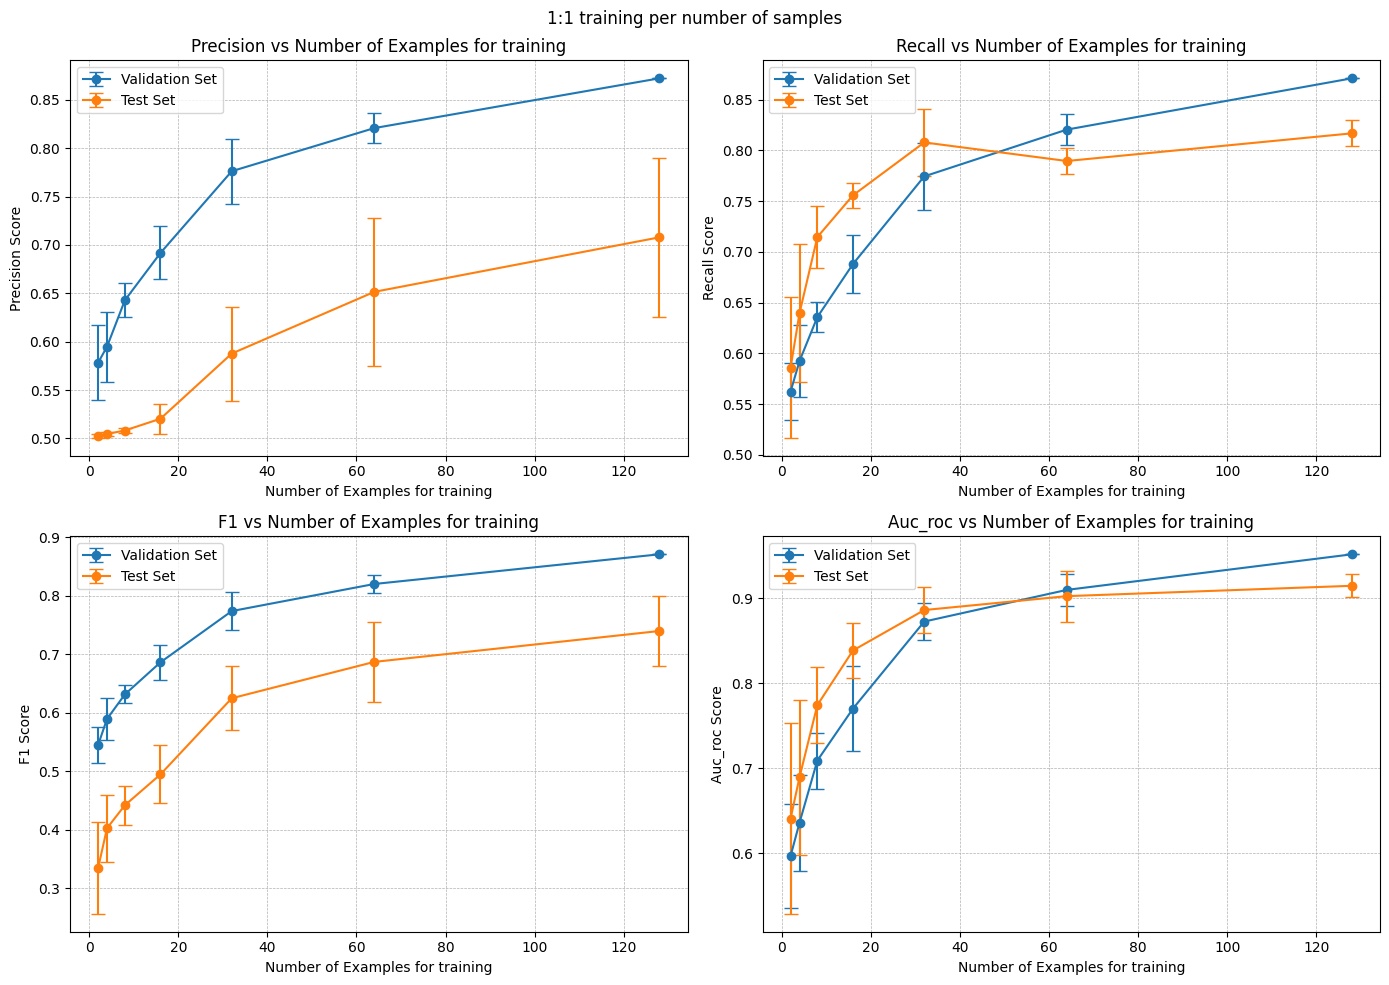

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Define test train examples
test_train_examples = [2, 4, 8, 16, 32, 64, 128]

# Extract metrics from metrics_dict
metrics = ['precision', 'recall', 'f1', 'auc_roc']

# Set up subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Plot each metric
for idx, metric in enumerate(metrics):
    # Get mean and std dev across seeds for each test train example
    # valid_means = [np.mean(valid_metrics_dict[metric][n]) for n in test_train_examples]
    # valid_std_devs = [np.std(valid_metrics_dict[metric][n]) for n in test_train_examples]
    
    # Get mean and std dev across seeds for each test train example
    test_means = [np.mean(test_set_metric_dict[metric][n]) for n in test_train_examples]
    test_std_devs = [np.std(test_set_metric_dict[metric][n]) for n in test_train_examples]

    # Plot with error bars
    # axes[idx].errorbar(test_train_examples, valid_means, yerr=valid_std_devs, fmt='-o', capsize=5, label="Validation Set")
    axes[idx].errorbar(test_train_examples, test_means, yerr=test_std_devs, fmt='-o', capsize=5, label="Test Set")
    axes[idx].set_xscale('linear')
    axes[idx].set_xlabel('Number of Examples for training')
    axes[idx].set_ylabel(f'{metric.capitalize()} Score')
    axes[idx].set_title(f'{metric.capitalize()} vs Number of Examples for training')
    axes[idx].legend()
    axes[idx].grid(True, which="both", linestyle="--", linewidth=0.5)

plt.suptitle('1:1 training per number of samples')
plt.tight_layout()
plt.show()